In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 400
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])

        pop = new_pop
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        print(f"Tempo: {t}")
        D = np.linalg.norm(Uto-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        rho_vector[0][t] = pt[0][0]
        rho_vector[1][t] = pt[0][1]
        rho_vector[2][t] = pt[1][0]
        rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        u[0] = resultado_algoritmo_genetico[0]
        u[1] = resultado_algoritmo_genetico[1]
        u[2] = resultado_algoritmo_genetico[2]
        aas.append((u[0],u[1],u[2]))
        # if 1/2*(1+rt[2][0]) > 0.9995:
        #     distance_vector.pop()
        #     fx_vector.pop()
        #     fy_vector.pop()
        #     fz_vector.pop()
        #     fid_vector.pop()
        #     fid_autores.pop()
        #     resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        #     u[0] = resultado_algoritmo_genetico[0]
        #     u[1] = resultado_algoritmo_genetico[1]
        #     u[2] = resultado_algoritmo_genetico[2]
        # while 1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1:
        #     resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        #     u[0] = resultado_algoritmo_genetico[0]
        #     u[1] = resultado_algoritmo_genetico[1]
        #     u[2] = resultado_algoritmo_genetico[2]
        #     a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        #     rt = np.dot(Uto, r0)
        #     pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        #     fid_vector[-1] = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        #     fid_autores[-1] = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        #     aas[-1] = ((u[0],u[1],u[2]))

        print(f"Valores ao longo do tempo")
        print(f"Distância: {distance_vector[-1]}")
        print(f"Fidelidade: {fid_vector[-1]}")
        print(f"Fidelidade da porta: {fid_autores[-1]}")
        
        t += 1
        Ut = Uto

    print(f"O rho gerado foi: {pt}") 
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Tempo: 0
Valores ao longo do tempo
Distância: 7.520643866970154
Fidelidade: (0.529920208021327-2.7495999720128377e-10j)
Fidelidade da porta: 0.2981646694280476
Tempo: 1
Valores ao longo do tempo
Distância: 5.955524204954155
Fidelidade: (0.6287250602713325+1.3984804023408511e-08j)
Fidelidade da porta: 0.24991970777917435
Tempo: 2
Valores ao longo do tempo
Distância: 3.782365395289647
Fidelidade: (0.7623226974298033+2.7304403238092144e-09j)
Fidelidade da porta: 0.3520381788436852
Tempo: 3
Valores ao longo do tempo
Distância: 1.677282824193208
Fidelidade: (0.8940745187804203-7.65418836062512e-09j)
Fidelidade da porta: 0.6384114216108919
Tempo: 4
Valores ao longo do tempo
Distância: 0.30132985022653597
Fidelidade: (0.9810067028877906+4.1525531932817415e-09j)
Fidelidade da porta: 0.9251502878628727
Tempo: 5
Valores ao longo do tempo
Distância: 0.025935705122968975
Fidelidade: (1.0021242365694092+2.7962867614438467e-10j)
Fidelidade da porta: 1.0101204567856765
Tem

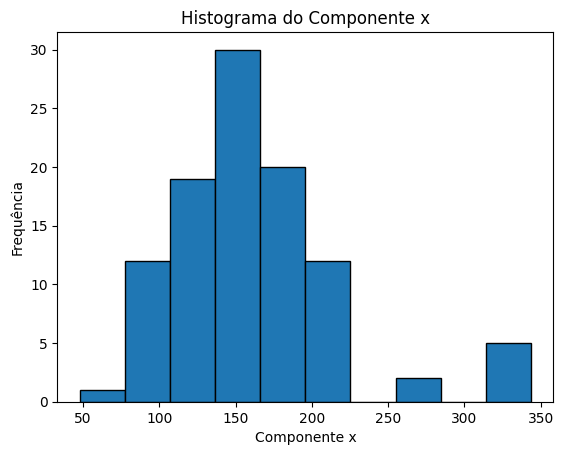

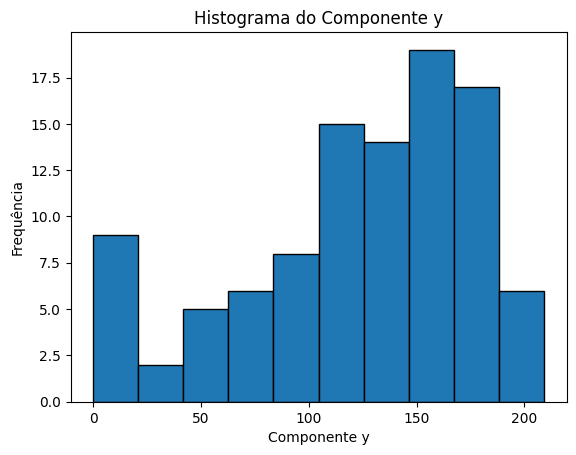

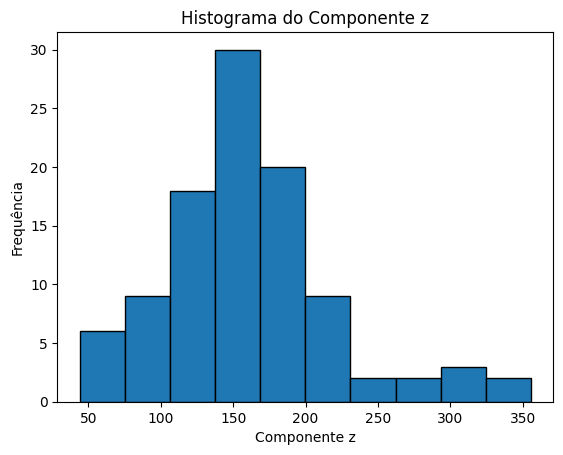

Terminou o histograma
Valores de média na iteração 1:
Portas: 1.0156513206172098
Estados: (1.0029691058367867+6.569269093636742e-12j)
Distância: 0.00031024145227388414
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[(0.529920208021327-2.7495999720128377e-10j),
 (0.6287250602713325+1.3984804023408511e-08j),
 (0.7623226974298033+2.7304403238092144e-09j),
 (0.8940745187804203-7.65418836062512e-09j),
 (0.9810067028877906+4.1525531932817415e-09j),
 (1.0021242365694092+2.7962867614438467e-10j),
 (1.003777014504784+3.498974739354814e-10j),
 (1.003879399716931+5.990067888502175e-11j),
 (1.0038831903837662+1.334562923139028e-12j),
 (1.0038737532601252-2.9754746241089406e-12j),
 (1.0038643179412168-1.4473465483019084e-10j),
 (1.0038550047845882-1.0223367359424486e-11j),
 (1.0038447797140149-1.1086429831688499e-10j),
 (1.0038349244091904-1.522392796786039e-11j),
 (1.0038247900559722+4.7426950561440054e-11j),
 (1.0038147228380476+1.1969268779121804e-10j),
 (1.0038047549216786+4.6525524408103515e-11j),
 (1.0037947330149766-5.692668534987056e-12j),
 (1.0037846452031849+1.1686176141836115e-10j),
 (1.0037742954680529+9.960438700290609e-12j),
 (1.0037643672089056-8.247258742479899e-11j),
 (1.0037543929602335-9.11

In [23]:
fid_autores

[0.2981646694280476,
 0.24991970777917435,
 0.3520381788436852,
 0.6384114216108919,
 0.9251502878628727,
 1.0101204567856765,
 1.0175468058952417,
 1.0180827417713236,
 1.0181118214213989,
 1.0180896764063405,
 1.0180631734946248,
 1.0180362779575367,
 1.0180091392215214,
 1.0179820155770214,
 1.0179548954893831,
 1.0179277514163159,
 1.0179006442386147,
 1.0178735064694873,
 1.0178463819307106,
 1.0178192147362413,
 1.0177920823269604,
 1.017764992269713,
 1.0177378639831056,
 1.0177107466028097,
 1.0176835828164612,
 1.017656460036882,
 1.0176293223748962,
 1.0176021832598576,
 1.0175750574179843,
 1.0175479691272715,
 1.01752082446328,
 1.0174937101917338,
 1.017466588391354,
 1.0174394680869494,
 1.0174123539724225,
 1.0173852338679878,
 1.0173581385934514,
 1.0173310319751725,
 1.0173038877684302,
 1.017276790600988,
 1.0172496885914273,
 1.0172225454943964,
 1.0171954252887148,
 1.0171683332769288,
 1.017141208338038,
 1.0171141158347767,
 1.0170870288535252,
 1.0170599203072723

In [24]:
rho_vector

array([[0.5299202 +0.j        , 0.62872506+0.j        ,
        0.7623227 +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.46903705-0.17052447j, 0.37026565-0.31023048j,
        0.23562172-0.35428528j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.46903705+0.17052447j, 0.37026565+0.31023048j,
        0.23562172+0.35428528j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.4700798 +0.j        , 0.37127494+0.j        ,
        0.2376773 +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ]])

In [25]:
distance_vector

[7.520643866970154,
 5.955524204954155,
 3.782365395289647,
 1.677282824193208,
 0.30132985022653597,
 0.025935705122968975,
 0.002523186149897547,
 0.0005916678359467865,
 0.0003908541726976465,
 0.0003721687308846634,
 0.00036898591809560676,
 0.0003673709236842235,
 0.00036667861702174945,
 0.00036593189387747486,
 0.0003651755262259459,
 0.0003645178943046387,
 0.0003637206469031519,
 0.00036304592828989465,
 0.0003623242496048867,
 0.00036177546347611957,
 0.00036109291745347976,
 0.00036025200589753456,
 0.0003595614550820521,
 0.00035883635170808206,
 0.000358296693206968,
 0.0003575969474319815,
 0.000356960480488179,
 0.0003563354351737317,
 0.0003556636788642334,
 0.00035485446543894177,
 0.0003542651781879422,
 0.0003535628810477653,
 0.0003528922921142302,
 0.00035221782979374646,
 0.00035152334891382455,
 0.00035085754827918794,
 0.00035010032291885024,
 0.00034938854864400513,
 0.0003488300351899508,
 0.00034809601231344366,
 0.00034738805585487066,
 0.0003468386900475353

In [26]:
fx_vector

[343.62272216106965,
 400,
 400,
 400,
 400,
 -18.23909207552612,
 -8.49404247482187,
 3.9494508888531916,
 2.9193245574740088,
 0.4701842957210148,
 0.16878988116012508,
 0.023063190740699763,
 0.0025789801931191125,
 -0.005410969557919504,
 -0.008519538077851913,
 -0.025919681519297105,
 -0.011650430007428492,
 0.0002220496486820822,
 -0.0013939298909783349,
 0.0005194065121626734,
 -0.02723886435159356,
 -0.019140830991796864,
 -0.007610460278975606,
 -0.005615070744001499,
 0.0007483554784396829,
 -0.005294787035613535,
 -0.02144284975926869,
 0.005506590539428063,
 -0.027039285587066364,
 0.00932079874454228,
 -0.0011314603014025704,
 -0.02254490992142022,
 0.0034715089742664296,
 -0.029932071953644113,
 0.009929682418406749,
 0.0011849138150157312,
 -0.00427184197184452,
 0.0019288653655986365,
 0.0005092806847468989,
 -0.005641586168382562,
 -0.001408639260417066,
 -0.0035913779488672137,
 -2.271261436823102e-05,
 0.001520615770156608,
 -0.010136292394251817,
 -0.007875697642171

In [27]:
fy_vector

[2.4125687883339837e-08,
 -0.02755069226999068,
 7.744446102808325,
 0.8189879557378688,
 0.0629049423779382,
 0.6400009336548051,
 -0.13012891417305367,
 -0.07920259451099072,
 -0.07177993257173344,
 0.037032408071781014,
 0.11440024502725056,
 0.024222804243052315,
 -0.02648112031255473,
 0.014118264435015404,
 -0.0070140258715307435,
 0.00136059915045611,
 0.0032472339897527958,
 -0.001452141777800564,
 0.00035788817216642066,
 -0.04867497875481455,
 0.013840654682968023,
 0.002014055929769276,
 -0.007656108551442997,
 -0.009224570337304755,
 -0.044987241388961735,
 0.009090202696421967,
 0.003092462631842041,
 -0.0652569081531969,
 0.02607452755610784,
 -0.005343593249332562,
 -0.0008415043921419785,
 -0.012705682500738252,
 -0.001671995243604174,
 0.004610255397397595,
 -0.028063161338540088,
 0.009773136091147161,
 0.0007762810238126916,
 -0.00010041442824978986,
 -0.05110940440020027,
 -0.008142385514851191,
 -0.013433606892398059,
 0.004519674467801216,
 -0.04918878208359044,
 

In [28]:
fz_vector

[355.53969459409507,
 400,
 400,
 400,
 361.7890626267795,
 13.563428175768145,
 -2.5394662234992995,
 0.1133069648680532,
 1.7135730847336466,
 0.2273727414458088,
 0.2074984941968807,
 0.01898894153390171,
 0.0031087334758900242,
 -0.004550887594824221,
 0.0038862609831648576,
 -0.0036234111518687884,
 -2.8254996516929864e-06,
 -0.006155526555143176,
 -0.01197907288608585,
 -0.010528032190618652,
 0.0010175860536788262,
 -0.0010339053947193144,
 -0.0014279904499551466,
 -0.03617930917038839,
 -0.015025711695930727,
 0.0015217936756048434,
 0.00020934169804762148,
 0.0002180170781036772,
 -0.02862901290639258,
 -0.04486213047570531,
 -0.0722942642796651,
 -0.0025630573443799487,
 -0.040554846807319245,
 0.013288739756158435,
 0.004021374470097455,
 -0.035301520961211946,
 -0.007110670654721624,
 -0.00013145480808537946,
 -0.0012741909927114492,
 -0.0314863139231473,
 -0.0401542352685095,
 -0.05674183309991139,
 0.013313387325570386,
 -0.005294413088234723,
 -0.031912152622108975,
 0.0

In [29]:
a

[(343.62272216106965, 2.4125687883339837e-08, 355.53969459409507),
 (282.51103459112255, 0.001495746437352039, 322.6984510764323),
 (48.01543640885297, 5.859436988953428, 61.717021102221935),
 (121.04611844042545, 2.385099819617871, 104.2966728265074),
 (323.54458296072687, 0.0, 290.2561369225215),
 (327.70414521745533, 0.024035839396719737, 301.75029223452503),
 (338.3367940429728, 9.330426901841044e-05, 325.01206607279744),
 (273.3059346017084, 0.0020471234969396956, 317.2646871354169),
 (320.34915739429584, 3.191149496084344e-05, 251.8286847089713),
 (202.51956664916975, 39.8936717492925, 286.41821199210597),
 (166.81065774836947, 98.63042862550435, 184.58358551453688),
 (190.015286185886, 209.0679986144449, 200.97029514278114),
 (163.38874656854904, 74.21685774887581, 139.60187851407008),
 (127.16650169343637, 162.90256710622182, 120.12409677322528),
 (187.96659570838983, 113.34976408947443, 156.914642650304),
 (96.20052578546455, 124.15439207060112, 180.7546530007202),
 (193.03048